# Final Report
### CSE627 Project 1: Shelter Animal Outcome, details of this contest please refer to [this](https://www.kaggle.com/c/shelter-animal-outcomes) link.
By Xian Liu & Matth Spinelli

Our final model of for this classification model is a random forest model with hyperparameteres carefully tuned. We achieved logloss=0.71 on Kaggle test dataset, ranking top **8%** on the leader board. To explain our strategies and reasoning, this notebook will be devided into the following chapters:
- [Data Exploration & Feature Engineering](https://github.com/mspinelli/animal_shelter/blob/master/Final%20Report.ipynb#Data-Exploration-&-Feature-Engineering)
- [Data Cleaning & Preprocessing](https://github.com/mspinelli/animal_shelter/blob/master/Final%20Report.ipynb#Data-Cleaning-&-Preprocessing)
- [Random Forest](https://github.com/mspinelli/animal_shelter/blob/master/Classify.ipynb#Random-Forest)
- [Gradient Boosting](https://github.com/mspinelli/animal_shelter/blob/master/Classify.ipynb#Gradient-Boosting)
- [Ensemble](https://github.com/mspinelli/animal_shelter/blob/master/Classify.ipynb#Ensemble-of-RB-and-GB)
- [Kaggle Results](https://github.com/mspinelli/animal_shelter/blob/master/Classify.ipynb#Kaggle-Results)
- [Final conclusion](#Final-Conclusing:)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt    # note that the plots might look different depending on which version you have
import seaborn as sns

%pylab inline
np.random.seed(127)
sns.set_palette("hls", 5)

Populating the interactive namespace from numpy and matplotlib


## Data Exploration & Feature Engineering

In [4]:
animals = pd.read_csv("train.csv.gz", compression='gzip')
animals.info(verbose=True, null_counts=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
ID                object
Name              object
DateTime          object
OutcomeType       object
OutcomeSubtype    object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
dtypes: object(10)
memory usage: 2.0+ MB


Data provided are primarily in the form of objects/strings, which means they are categorical data. Random forest (RF), being a popular and powerful ensemble method, is one of the best known algorithms to deal with categorical data. The entire dataset has 26729 entries, 10 features including 1 Outcome. The size of the dataset is decent for RF. It is not clear why OutcomeSubtype is also provided here as it is excluded in the test data also provided by Kaggle. We did not use this feature in any of the following processes.

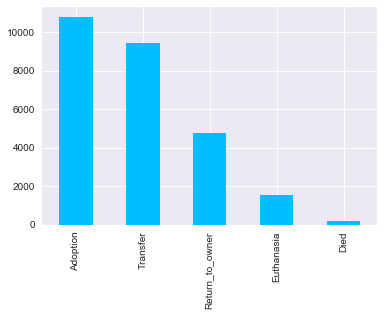

In [5]:
animals.OutcomeType.value_counts().plot(kind="bar", color="deepskyblue")

Here we show the the overall "OutcomeType" in of the entire dataset. It is quite clear that we have an unbalanced sample size across our target. This will result in misclassification in our model.

Our target column is "OutcomeType". To warm up, we were interested to see how "AnimalType" and "SexuponOutcome" affect an animal's outcome. We think these two should rank one of the highest predictors when it comes to animal outcome.

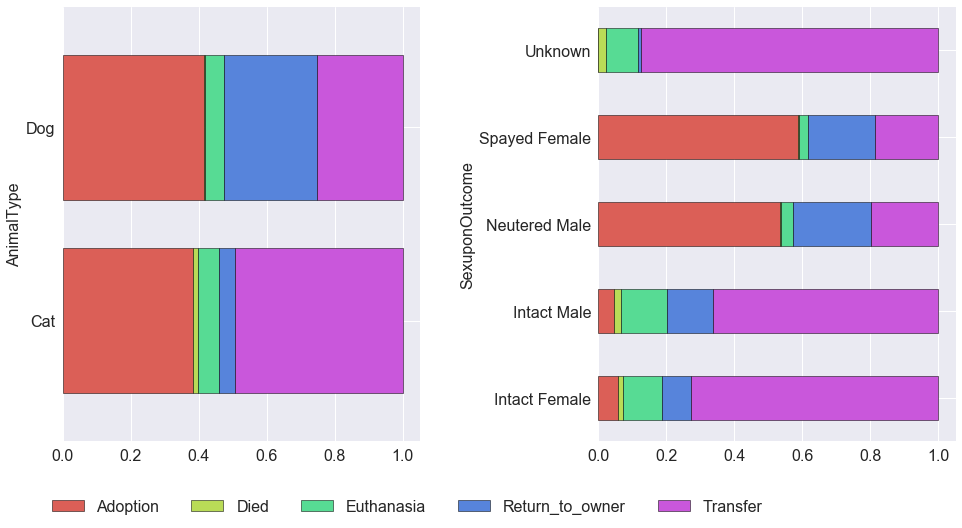

In [6]:
f, axs = plt.subplots(ncols=2)

axs[0].yaxis.label.set_size(16)
axs[1].yaxis.label.set_size(16)

f.set_size_inches(16, 8)
plt.subplots_adjust(wspace=.5)

(animals
 .groupby("AnimalType")
 .OutcomeType
 .value_counts(normalize=True)
 .unstack()
 .plot(kind="barh", stacked=True, ax=axs[0], width = 0.75, 
       fontsize=16, edgecolor='k', linewidth=0.5)
 .legend(fontsize=16, ncol=5, bbox_to_anchor=(2, -.1))
)

(animals
 .groupby("SexuponOutcome")
 .OutcomeType
 .value_counts(normalize=True)
 .unstack()
 .plot(kind="barh", stacked=True, ax=axs[1], fontsize=16, 
       edgecolor='k', linewidth=0.5, legend=False)
);

Here we show for each "AnimalType" and "SexuponOutcome", how different types of "OutcomeType" is distributed.  
We have several findings here:
* Both dogs and cats has a low "Euthanasia" and "Died" rate, good news.
* Dogs are significantly more likely to be "Return_to_owner" than cats.
* Cats has a higher "Transfer" rate
* Intact + Unknown animals are more likely to be transfered. If we want to increase adoption rate, we should get animals neutered.
* "Unknown" group never gets adopted. So far we don't know what other information we can draw from these features, we'll leave them as is.

Next, we check missing values:

In [7]:
for c in animals.columns:
    print "{} has: {} missing values".format(c, animals[c].isnull().sum())

ID has: 0 missing values
Name has: 7691 missing values
DateTime has: 0 missing values
OutcomeType has: 0 missing values
OutcomeSubtype has: 13612 missing values
AnimalType has: 0 missing values
SexuponOutcome has: 1 missing values
AgeuponOutcome has: 18 missing values
Breed has: 0 missing values
Color has: 0 missing values


### Name
Name might not seem like the first feature that matters when it comes to the outcome of an animal. However, having a name or not might affect the outcome of an animal, let's try it out.
One interesting finding is that all animals that are named 'X' are transfered. We reason this is another way of addressing an animal when transferring it without knowing its name. 

In [8]:
print "When Name is X, outcome of this animal is {}".format(animals[animals.Name == 'X'].OutcomeType.unique())

When Name is X, outcome of this animal is ['Transfer']


Thus, we decide to map both 'X' name and np.nan values as no name. 

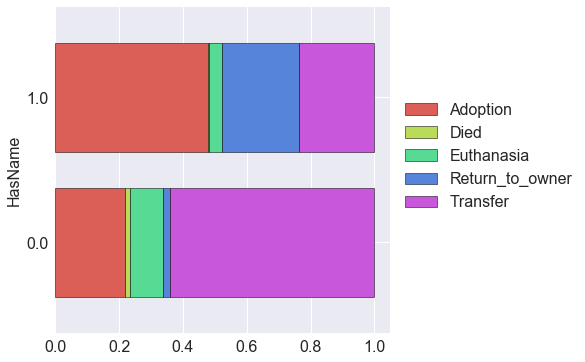

In [9]:
animals['HasName'] = animals.Name.map(lambda x : 0 if x == 'X' else 1, na_action='ignore')
animals['HasName'].fillna(value=0, inplace=True)

(animals
 .groupby("HasName")
 .OutcomeType
 .value_counts(normalize=True)
 .unstack()
 .plot(kind="barh", stacked=True, figsize=(6,6), width = 0.75, 
       fontsize=16, edgecolor='k', linewidth=0.5)
 .legend(fontsize=16, ncol=1, bbox_to_anchor=(1, 0.75))
)
ax = plt.gca()
ax.yaxis.label.set_size(16)

Like we predicted, having a name did help the animal to get adopted. Animal shelters could try to all their animals to increase their chances of being adopted. Named animals are most likely to be sent to the facility by previous owner due to various reasons, but not abandoned. These owners still care about their pets, this could explain why named animals have a higher return_to_owner rate.

## DateTime Features

  The DateTime field is a quite interesting field. It indicates the time when the outcome happens, which does not make a lot of sense when we try to "predict" an animal's outcome. However, the practical value of studying this feature lies in the information we can provide animal shelter staff to increase rate of adoption. If they know when most adoption happens, they can get the animals ready beforehand.

  We would like to add additional features indicating timeofday, weekofyear, etc for each DateTime value

In [10]:
from customize_plots import plot_feature

In [11]:
animals['Timestamps'] = pd.to_datetime(animals['DateTime'])
print "Our records are between the range {} to {}".format(animals.Timestamps.min(), animals.Timestamps.max())

Our records are between the range 2013-10-01 09:31:00 to 2016-02-21 19:17:00


In [12]:
# Converting timestamps to several potential groups
animals['Year'] = animals.Timestamps.dt.year
animals['Month'] = animals.Timestamps.dt.month
animals['Weekday'] = animals.Timestamps.dt.weekday
animals['Hour'] = animals.Timestamps.dt.hour
animals['WeekofYear'] = animals.Timestamps.dt.weekofyear
animals['DayofMonth'] = animals.Timestamps.dt.day

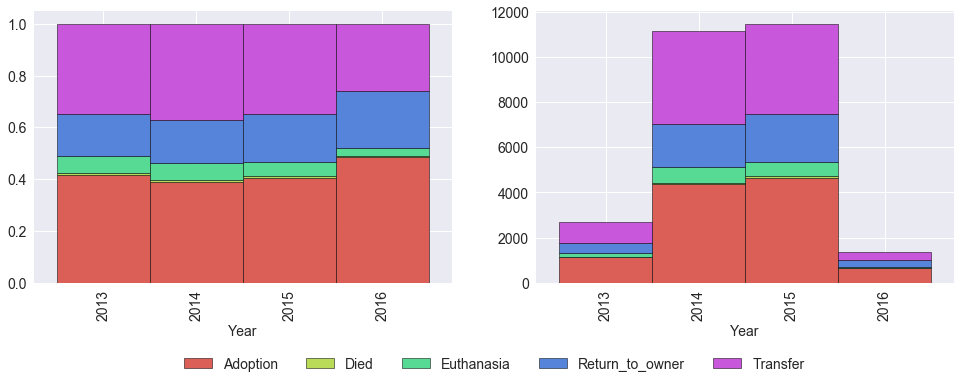

In [13]:
plot_feature("Year", data=animals)

Year does not seem to be an important feature as percentage-wise it does not affect animal outcome very much with the exception of 2016. However, since we have a lot less samples in 2016, the percentage advantage of later year is hard to infer.

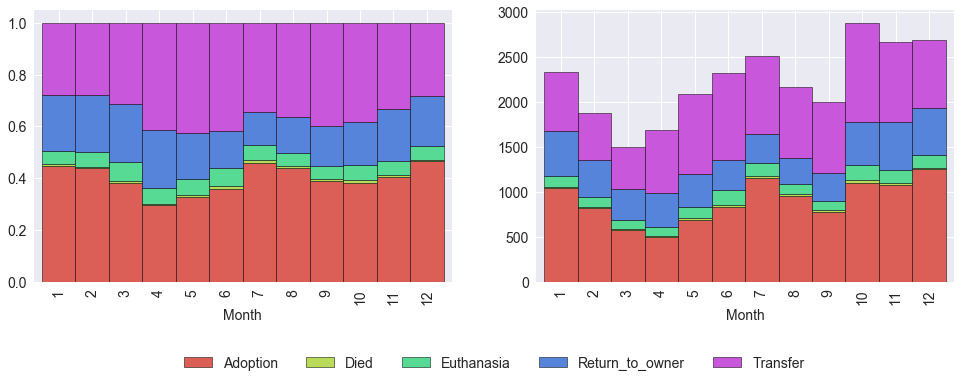

In [14]:
plot_feature("Month", data=animals)

Animals do have a better chance of being adopted in Jan, Jul and Dec. But the distribution is not quite distinct throughout the year.

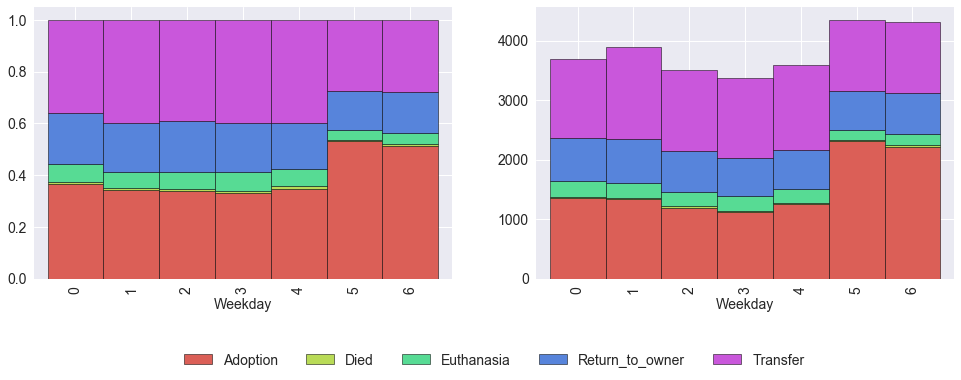

In [15]:
plot_feature("Weekday", data=animals)

Fridays and Saterdays have a higher adoption rate but lower than average transfer rate, but this "weekend" pattern does not hold for Sunday. 

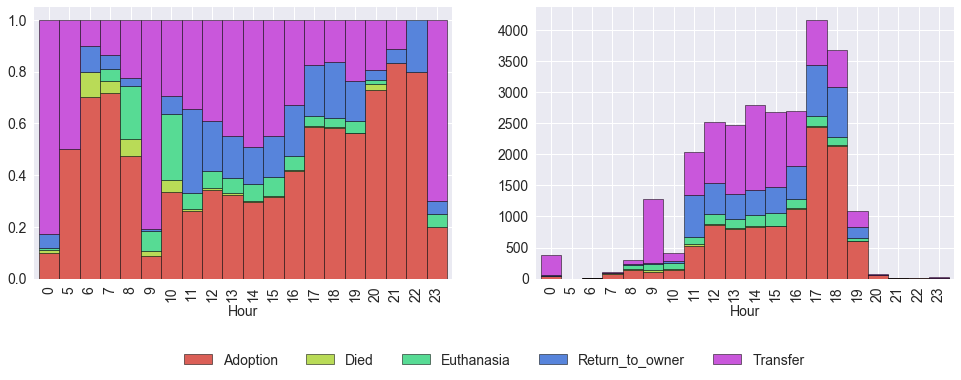

In [16]:
plot_feature("Hour", data=animals)

There is a surge of transfer around 9am in the morning. Most adoptions happend in the late afternoon to early evening range.

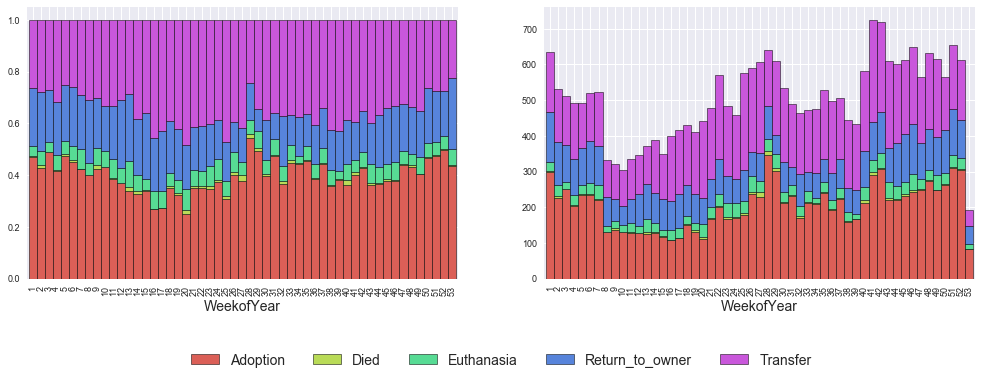

In [17]:
plot_feature("WeekofYear", data=animals, width_inches=17, tick_font_size=9)

Week 27-28 seems to be the "Lucky Weeks" of the entire year, both in tems of count and percentage of animals being adopted. It seems like people like to get their kids new pets when the summer break just started. Another popular time is first couple of weeks after new year.

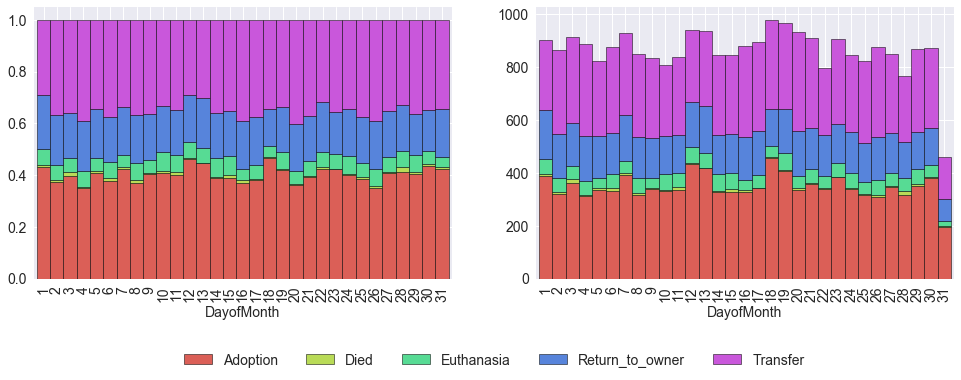

In [18]:
plot_feature('DayofMonth', data=animals)

This does not seem to be a very useful feature so far.

We implemented "MyHolidays" class using public holiday information of the state Taxas. Our definition of holiday also includes the holiday seasons "Dec, Jan" and summer break. We also added addtional holidays like "Valentine's Day" (we all know girls love pets). 

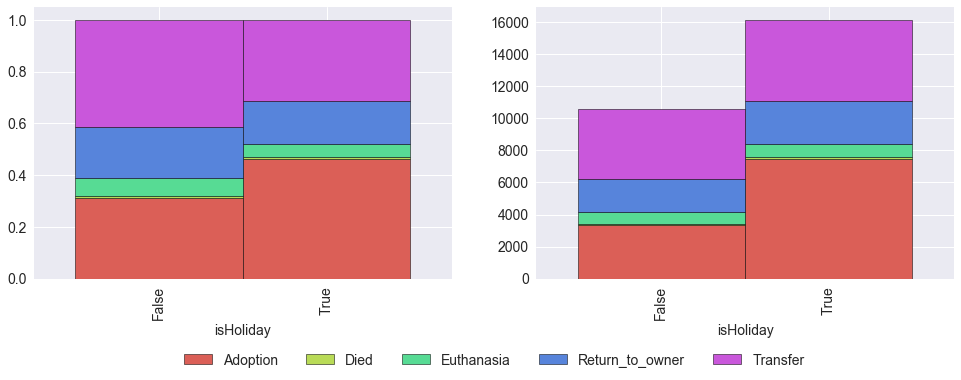

In [19]:
import MyHolidays

tx_holidays = MyHolidays.MyHolidays(state="TX", years =[2015])
def is_holiday(dt):
    if (dt.month in [1,12,7,8]) or (dt.date() in tx_holidays) or dt.weekday() in [5,6]:
        return True
    return False

animals["isHoliday"] = animals.Timestamps.apply(is_holiday)
plot_feature("isHoliday", data=animals)

Like we predicted, holidays do make a difference when it comes to animal outcome. Staff can focus more on getting animals nice and clean before holidays.

## AgeuponOutcome 
We need to use the same unit on AgeuponOutcome feature. We decide to convert all of them into days. 

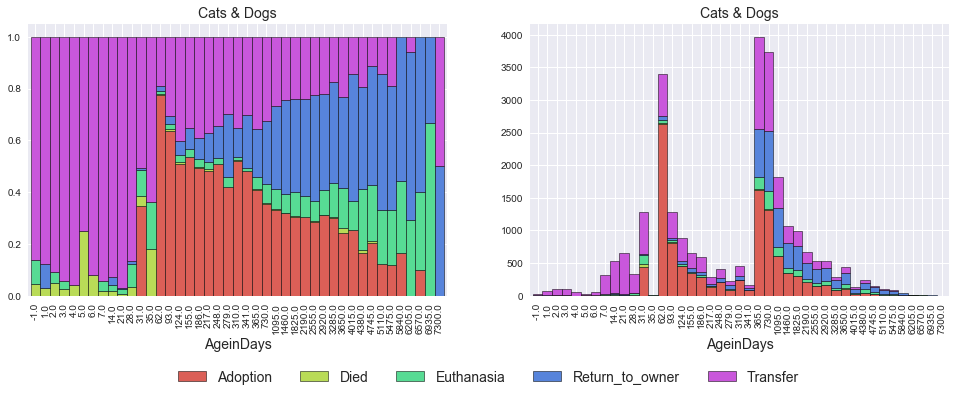

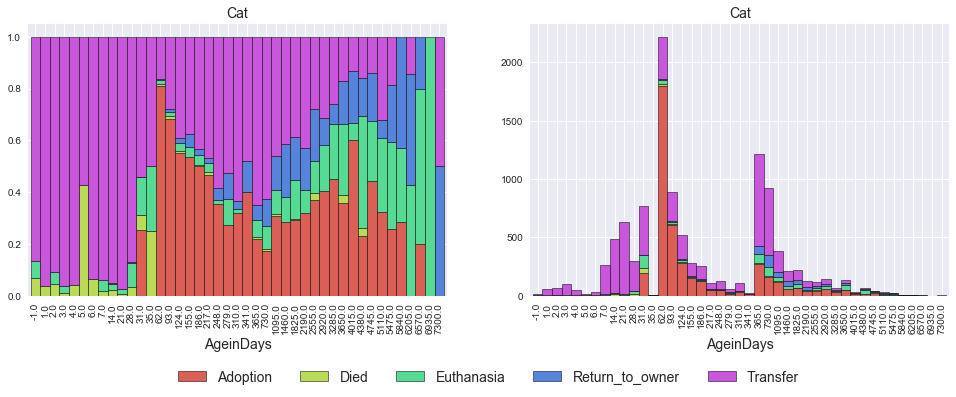

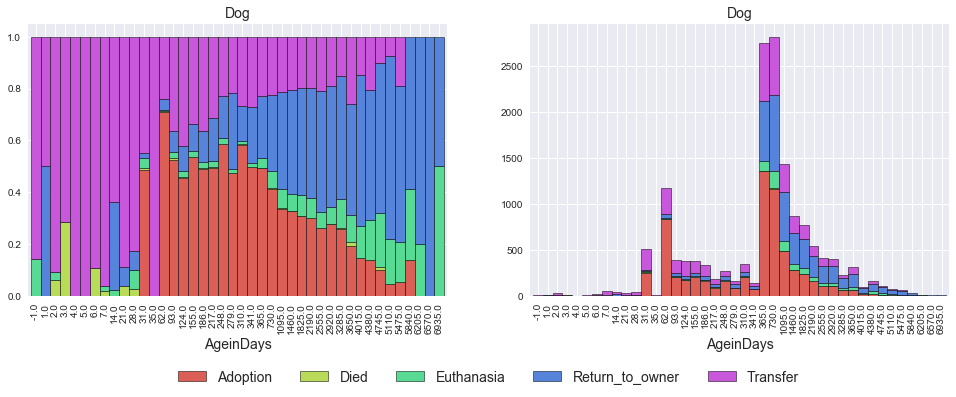

In [20]:
units = {"year" : 365, "month":31, "day":1, "week":7}

def get_age_in_days(agestring):
    tokens = agestring.split(" ")
    unit = tokens[1].replace("s","")
    days = int(tokens[0]) * units[unit]
    # return days
    return days if days != 0 else -1

animals["AgeinDays"] = animals.AgeuponOutcome.map(get_age_in_days, na_action="ignore")

plot_feature('AgeinDays', animals, tick_font_size=10, title='Cats & Dogs')
plot_feature('AgeinDays', animals, filter_=animals.AnimalType=='Cat', tick_font_size=10, title='Cat')
plot_feature('AgeinDays', animals, filter_=animals.AnimalType=='Dog', tick_font_size=10, title='Dog')

We have more younger cats than dogs. No surprise, people prefer younger animals. The most popular age group is roughly 2 month, for both dogs and cats. Unlike dogs, older cats still have a good chance of being adopted even after turning 11, although the actual count is very low. 

Note that some animals has an age of "0 years".
The interesting finding is that all animals are missing age info happened in a very small time window.

In [21]:
print "Animals missing age are in the time window {} to {}".format(
    animals[animals.AgeinDays.isnull()].Timestamps.min(), 
    animals[animals.AgeinDays.isnull()].Timestamps.max())

Animals missing age are in the time window 2016-02-09 19:43:00 to 2016-02-21 18:22:00


In [22]:
# if we comebine them with all the AgeinDays == 0 animals, the outcome looks like this: No one was adopted
animals[(animals.AgeinDays.isnull()) | (animals.AgeinDays==-1)].OutcomeType.value_counts()
# So we decide to group nan and 0 year animals to -1

Transfer      35
Euthanasia     4
Died           1
Name: OutcomeType, dtype: int64

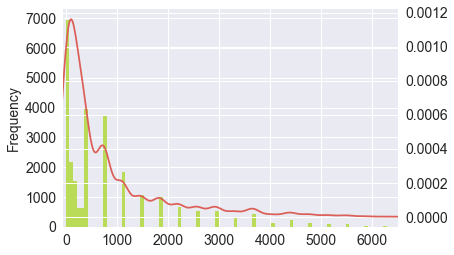

In [23]:
# Now the distribution of ageindays looks like:
fig, ax = plt.subplots()
animals["AgeinDays"].plot(fontsize=14, kind="kde", ax=ax, xlim=(-50, 6500), secondary_y=True)
animals["AgeinDays"].plot(fontsize=14, kind="hist", bins=100, xlim=(-50, 6500),  ax=ax, zorder=2)
twin_ax = ax.figure.axes[1]
ax.yaxis.label.set_size(14)
[tick.set_fontsize(14) for tick in twin_ax.yaxis.get_ticklabels()];

The probability distribution is greatly affected by the records (very discrete). If we want to treat the age feature as discrete, there will be too many classes, and RF would not perform well in this case. We decide to also map ages to infant, child, young adult, adult and old groups. 

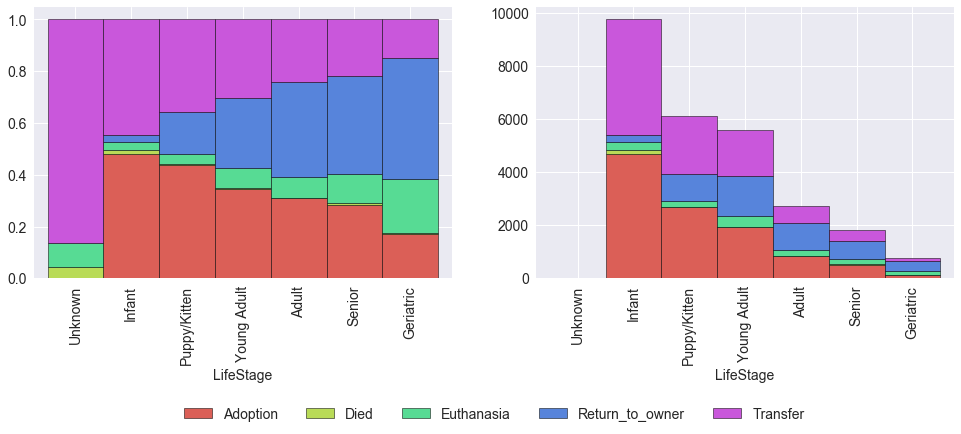

In [24]:
bins = [-5, 0, 5 * units["month"], 12 * units["month"], 3*units["year"],
        6 * units["year"], 10*units["year"], 20 * units["year"]]
labels = ["Unknown", "Infant", "Puppy/Kitten", "Young Adult", "Adult", "Senior", "Geriatric"]

animals["LifeStage"] = pd.Categorical(pd.cut(animals.AgeinDays, bins=bins, labels=labels), categories=labels)

plot_feature('LifeStage', data=animals, legend_offset=-.5)

### SexuponOutcome

In [25]:
animals[animals.SexuponOutcome.isnull()]

,ID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,Timestamps,Year,Month,Weekday,Hour,WeekofYear,DayofMonth,isHoliday,AgeinDays,LifeStage
3174,A667395,Diego,2013-11-27 16:11:00,Return_to_owner,NaN,Dog,NaN,7 years,Dachshund,Brown Merle,...,2013-11-27 16:11:00,2013,11,2,16,48,27,False,2555.0,Senior


In [26]:
animals[(animals.SexuponOutcome.str.contains("Male")) & 
        (animals.AgeuponOutcome=="7 years")&
        (animals.AnimalType=="Dog") &
        (animals.OutcomeType=="Return_to_owner")
       ].SexuponOutcome.value_counts()

Neutered Male    97
Intact Male      13
Name: SexuponOutcome, dtype: int64

In [27]:
# Given its name other info, I guess it is a male, so we narrowed down to all similar animals and 
# assign the majority sex to it.
animals.loc[3174, "SexuponOutcome"] = "Neutered Male"

As was shown before, "Unknown" sex has a distictive distribution of outcome compared with other sex, we decide to
leave it as one class. We ended up imputing all missing values in this dataset using datapoints that has the most similarity to these missing data. We implemented "multinomial_impute" in our module `clean.py`. 

So we impute all these randomly with the top two sex within age range (0 days - 2 month).

In [28]:
unknowns = animals[animals.SexuponOutcome == "Unknown"]

# so we try to see what their most shared features here
print "AnimalType Mode: ", unknowns.AnimalType.agg('mode')[0]
print "AgeinDays Median: ", unknowns.AgeinDays.median()
print "OutcomeType Mode:", unknowns.OutcomeType.mode()[0]
print "HasName Mode", unknowns.HasName.mode()[0]

AnimalType Mode:  Cat
AgeinDays Median:  21.0
OutcomeType Mode: Transfer
HasName Mode 0.0


These animals are mostly cats, 21 days old, no name and ended up being transfered. We pull out all records that fits this criteria:

In [29]:
print "Total number of: ", len(unknowns)
p = animals[(animals.AnimalType=="Cat") & 
        (animals.AgeinDays<= 31) & 
        (animals.OutcomeType=="Transfer") &
        (animals.HasName==0) & 
        (animals.SexuponOutcome!="Unknown" )].SexuponOutcome.value_counts(normalize=True)
print p

Total number of:  1093
Intact Male      0.533679
Intact Female    0.463360
Neutered Male    0.002961
Name: SexuponOutcome, dtype: float64


### Breed and Color

We need more information about "Breed". So we got some information from online sources [here](http://www.sorteaze.com/dog-breed-personality--social-traits.html) and [here](http://www.sorteaze.com/dog-breeds.html). Our script `load_dog_data()` is capable of scraping info from these sites from scratch. Unfortunately, this website is now giving 404 error. So we are loading our backup copy.

We think dog size and their characteristics are key features when people look for dogs. However, considering lots of shelter animals were abused, their characteristic may change. Not sure if dog personalities would be important in this case, but we are kept it anyway. We will let our classifier decide the importance of features. You can find our code in `clean.py` and [this notebook](https://github.com/mspinelli/animal_shelter/blob/master/DataExplore.ipynb). We made features "MixType", "AvgWeight", "Friendliness", and "Intelligent" using Breed information. For this part of the work, correctly parsing and merging different dataframe information is crucial.

For the "Color" field, we made "Hair", "Blended Color" and "Reduced Pattern". Details can be found in the same notebook. The problem of "Color" is the fact that there are too many colors. We chose to parse our colors and blend colors when a dog has multiple colors and finally get the colors reduced to 22 classes.

In [30]:
from customize_functions import load_clean_dog_data
from clean import add_dog_data, mix_type

dog_data_clean = load_clean_dog_data()
dog_data_clean.head()

,BreedName,AvgWeight(pounds),SizeScore(1to5),Intelligent,Friendliness
0,Affenpinscher,10,1,3.0,3.6
1,Afghan Hound,55,4,2.0,2.8
2,Airedale Terrier,53,3,4.0,3.0
3,Akita,105,5,2.0,2.0
4,Alaskan Klee Kai,15,2,3.0,3.2


### Conclusion

Feature engineering is about finding important features from the dataset. Making plots are great ways to help we reason the importance of different data. There are many data visualization libraries available, and for this project we tried ggplot, matplotlib, seaborn and pandas own plotting functions (implemented by matplotlib). Syntactically, We find pandas plot gives best result with the minimum amount of code. Since it is built on top of matplotlib, the customizability is quite good as well. 

Given that our dataset is multidimensional, we think it is a good idea to engineer more features than we need and let the classifier pick the good ones. We made the mistake of only picking features that made sense to use, which finally resulted in not so great classifiers.

The module `clean.py` in this repo is the data cleaning workflow we created for this project. With the experience from this project, we suggest **NOT to clean your data in an ipython notebook**. Ipython Notebook is a convinient tool for test ideas, but given the fact that you can run the notebook in different order will make the cleaning process inconsistent across multiple runs. Especially at the stage when you are testing new ideas and tweaking the ways of making new features and imputing values. Feature engineering is the foundation of any good classifier, keeping the result consistent will make any following work a lot more efficient. 

## Data Cleaning & Preprocessing

Unfortunately, scikit-learn only has the most basic imputer that supports "mean", "median" and "mostfrequent". We found two packages that do advanced imputation algorithms. We cannot get fancyimpute up and running on the machine we use. Orange does not quite give us what we want. Although Orange3 might work, it requires python3. We tried several schemes to impute our missing data, including most frequent, mean etc. We found the following multinomial-impute serves the best on our model. 

Another way of impute we could try is model-based impute. We did not have much time to explore this method, but we did try to build simple tree models on non-missing features and let the tree "predict" missing values. This is essentially an clustering method, but the outcome was not good enough, possibly due to the quality of these trees that we built. Another popular method, which is implemented in Orange also, is 1-NN clustering, which is suppose to work on a mixture of continuous and categorical data. This requires we scale our naievely labeled categorical data or convert it to one-hot. Although we'd love to try it, we was not able to find it in the older version of Orange.

In [31]:
from clean import make_features, impute_features

In [32]:
train = make_features(status="train")
test = make_features(status="test")

clean.py:132: RuntimeWarning: Mean of empty slice.
  .mean(axis=0)


In [33]:
def multinomial_impute(series, data):
    """
    :param series: a pandas.Series that is filtered to be very similar to missing values properties. 
    We count per class probability in this series.
    :param data: the original dataframe we want to impute changes on.
    return: a numpy array which has the same size as the number of null values in the series.
    """
    vc = series.value_counts(normalize=True)
    values = vc.axes[0].tolist()
    ps = vc.tolist()
    
    assert len(values) == len(ps)
    
    sample = np.random.multinomial(1, ps, size=data[series.name].isnull().sum())
    vs = array([values[i] for i in sample.argmax(axis=1)])
    data.loc[data[series.name].isnull(), series.name] = vs

train_imputed = impute_features(train)  # impute_features function uses multinomial_impute under the hood
test_imputed = impute_features(test)

### Categorical Encoder

After all the features being extracted, we are ready to convert our categorical data into numerical data. One of the best things about the random forest model is that it **does not** require one-hot encoding for categorical data. We use [this package](http://contrib.scikit-learn.org/categorical-encoding/index.html) for categorical encoding. 
As one-hot increases dimension dramatically, after reading [this artical](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/), we decide to try "Binary Encoder", "Ordinal Encoder" and "One-hot Encoder".

**Friendly Note: When encoding categorical data, make sure you fit both the train and test data! Otherwise the way the encoder works will be inconsistent on test vs. train. THIS RUINS EVERYTHING**

*These are our sample code of doing binary encoding*

In [34]:
train_imputed.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,HasName,Year,...,SizeScore(1to5),Intelligent,Friendliness,AvgAge,MixType,Hair,BlendedColor,ReducedPattern,OutcomeType,OutcomeSubtype
0,A671945,Hambone,2014-02-12 18:22:00,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1.0,2014,...,2.0,5.0,4.0,13.0,Mix,Short,rosybrown,BiColor,Return_to_owner,NaN
1,A656520,Emily,2013-10-13 12:44:00,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1.0,2013,...,1.0,3.0,3.0,13.0,Mix,Short,tan,Tabby,Euthanasia,Suffering
2,A686464,Pearce,2015-01-31 12:28:00,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,1.0,2015,...,4.0,3.0,2.0,12.0,Mix,Short,silver,BiColor,Adoption,Foster
3,A683430,NaN,2014-07-11 19:09:00,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,0.0,2014,...,1.0,3.0,3.0,16.0,Mix,Short,rosybrown,Solid,Transfer,Partner
4,A667013,NaN,2013-11-15 12:52:00,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,0.0,2013,...,2.0,4.0,4.0,15.0,Cross,Short,tan,Solid,Transfer,Partner


In [35]:
test_imputed.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,HasName,Year,...,BernoulliSex,AvgWeight(pounds),SizeScore(1to5),Intelligent,Friendliness,AvgAge,MixType,Hair,BlendedColor,ReducedPattern
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White,1.0,2015,...,Intact Female,68.0,4.0,5.0,4.0,13.0,Mix,Short,salmon,BiColor
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan,1.0,2014,...,Spayed Female,59.0,4.0,4.0,3.0,12.0,Cross,Short,darkolivegreen,BiColor
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby,1.0,2016,...,Neutered Male,9.0,1.0,3.0,3.0,13.0,Mix,Short,brown,Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor,1.0,2013,...,Intact Male,16.0,2.0,4.0,3.0,13.0,Mix,Medium,Not_clear,Solid
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White,1.0,2015,...,Neutered Male,14.0,2.0,5.0,4.0,16.0,Mix,Short,white,Solid


In [36]:
# first we pick all cols we need to encode
col = [3] + range(8,28)
train_obj = train_imputed.iloc[:, col].copy()
test_obj = train_imputed.iloc[:, col].copy()
total_df = pd.concat([train_obj, test_obj], axis=0)

import category_encoders as ce

encoder = ce.BinaryEncoder(verbose=1, cols=total_df.columns.tolist(), drop_invariant=False, return_df=True, impute_missing=True, handle_unknown="impute")
encoder.fit(total_df, verbose=1)       # fit the total_df
train_df_binary = encoder.transform(train_obj)
test_df_binary = encoder.transform(test_obj)

### Chapter Conclusion:
We tried several imputing and encoding algorithms in this part of the project. Unfortunately, scikit-learn has limited algorithm implemented for this part of the job. Other useful libraries include Orange, fancyimpute, categorical_encoders. We will further discuss the performance of each strategy in later chapters. 

## Final Conclusion:
A combination of multinomial imputation, ordinal-encoding and RF with hyperparameters carefully tuned using grid-search gives the best performance we have so far. Theoretically, we think GB (compared to RF), one-hot encoding, and binary encoding should improve our performance but we was not able to achieve that in general. However a major exception is that when GB is combined with RF in an ensemble this did better than RF alone. We also explored Logistic Regression, but results were much worse using this classifer. It did however benefit some by using one-hot encoding.

- We confirmed that ordinal-encoding performed best for this dataset using the RF and GB discriminatory classifers. For Logistic Regression we think that ordinal-encoding did worse partially because when the classifier group for example hair class 1 and hairclass 2 together, these two classes actually have nothing in common, they are just numerically closser. Binary encoding logrithmically reduces the dimensionality of our dataset. However, since the classifier picks columns at random, it misses the idea that several columns combined actually represents the real feature. It might also because our dataset is not "high dimension" enough for the benefit of binary-encoding to show. 

- Theoretically, linearly transposed data does not increase the performance of RF. We could try to use other basis function such as radial basis to better seperate our dataset.

- One reason why we think GB did not perform better than RF is because spent a lot of time optimizing random forest, and not as much time spend on GB. Additionally, GB takes much longer to run, can't be parallelized, and there are more hyper-parameters to set so learning and tuning is harder and slower. We suspect also that GB might perform better with more data because the classifer is more complex than RF.

- The rare classes of died and euthanasia posed some challenges to the classifers becuase there just wasn't enough samples of these to predict accurately. We tried to use balanced class weights on RF, GB, and LR. This doesn't really help us though because the metric we are being evaluated on is log loss. If we cared more about F1 score, then maybe balanced class weights would have been useful.